# Import relevant libraries 

In [1]:
!pip install datasets transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 47.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.29.2
    Uninstalling transformers-4.29.2:
      Successfully uninstalled transformers-4.29.2


In [2]:
#Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import necessary libraries
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
from transformers.data.processors import SingleSentenceClassificationProcessor
from transformers import Trainer , TrainingArguments
from transformers.trainer_utils import EvaluationStrategy
from transformers.data.processors.utils import InputFeatures
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.utils import resample

#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Seed for reproducibility
import random

seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
import numpy as np
import pandas as pd
data = pd.read_csv('/kaggle/input/amazon-books-reviews/Books_rating.csv')
data.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


# Clean / Preprocessing / Discover Data 

In [4]:
data = data.drop(['Id' , 'Title' , 'Price','User_id','profileName','review/helpfulness','review/time','review/summary'], axis=1)
data = data.rename(columns={"review/text":"review" , "review/score":"label"})
print(data.head())

   label                                             review
0    4.0  This is only for Julie Strain fans. It's a col...
1    5.0  I don't care much for Dr. Seuss but after read...
2    5.0  If people become the books they read and if "t...
3    4.0  Theodore Seuss Geisel (1904-1991), aka &quot;D...
4    4.0  Philip Nel - Dr. Seuss: American IconThis is b...


In [5]:
data["label"].value_counts()

5.0    1807343
4.0     585616
3.0     254295
1.0     201688
2.0     151058
Name: label, dtype: int64

In [6]:
def mark_sentiment(rating):
    if(rating > 3.0):
        return 2
    elif (rating == 3.0):
        return 1
    else:
        return 0
data["label"] = data['label'].apply(lambda x:mark_sentiment(x))
data["label"].value_counts()

2    2392959
0     352746
1     254295
Name: label, dtype: int64

In [7]:
data.drop_duplicates(inplace=True)
data = data.dropna(axis=0)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2062913 entries, 0 to 2999999
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   label   int64 
 1   review  object
dtypes: int64(1), object(1)
memory usage: 47.2+ MB
None


In [8]:
print(data.shape)
data["label"].value_counts()

(2062913, 2)


2    1630523
0     255457
1     176933
Name: label, dtype: int64

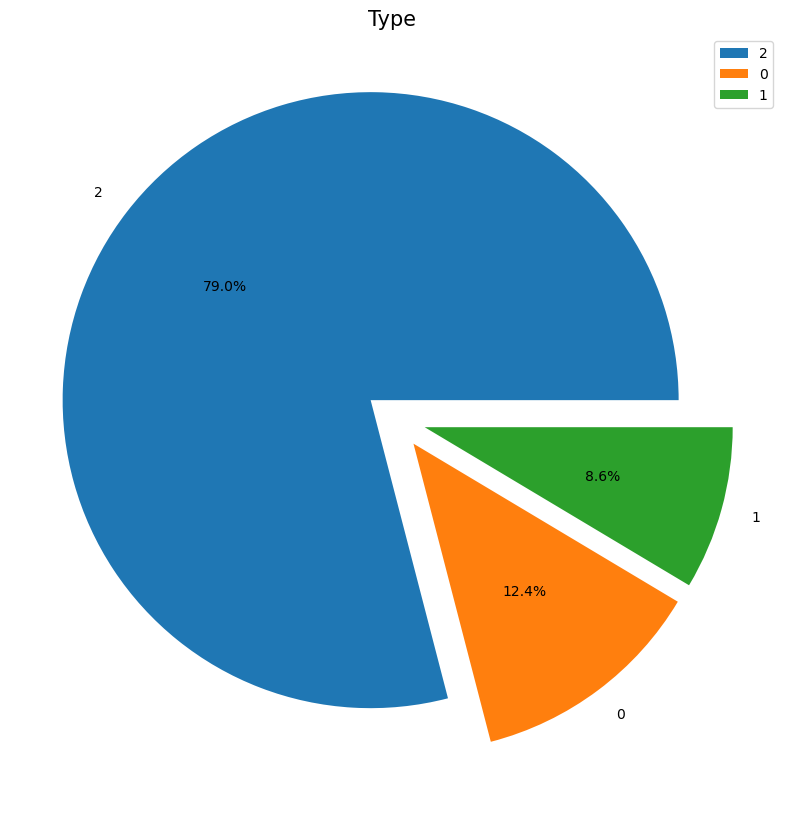

In [9]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 10)
labels=[2,0,1]
plt.pie(data['label'].value_counts(),explode =(0.1,0.1,0.1), labels=labels,autopct='%1.1f%%')
plt.title('Type ', fontsize = 15)
plt.axis('off')
plt.legend()
plt.show()

# Balance Classes

In [10]:
class_0 = data[data["label"] == 0]
class_0  = class_0.iloc[:176933]
class_1 = data[data["label"] == 1]
class_2 = data[data["label"] == 2]
class_2  = class_2.iloc[:200933]
data = pd.concat([class_2 , class_0])

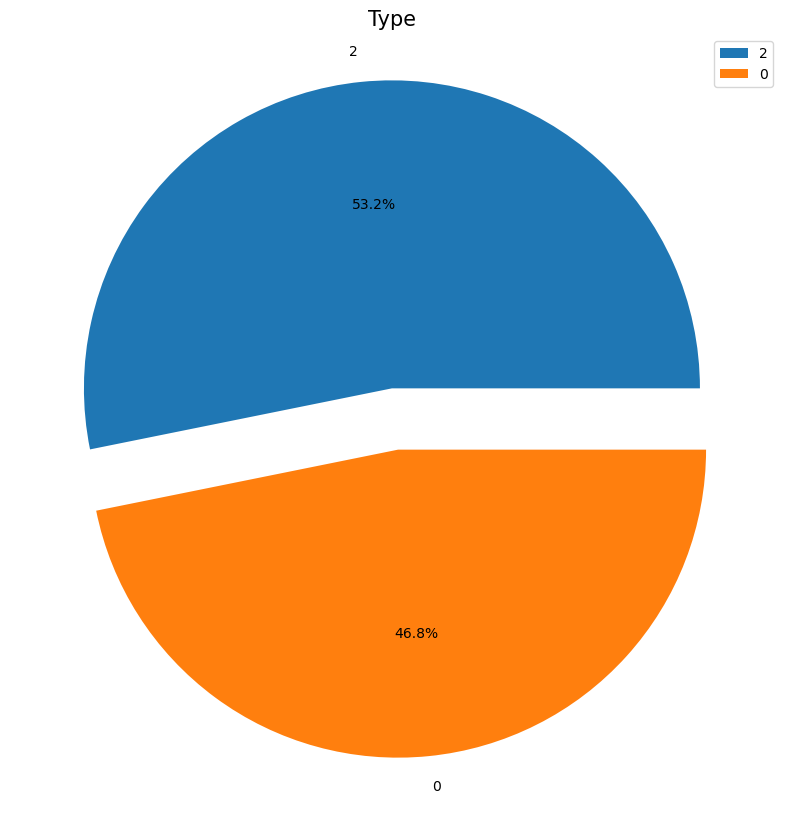

In [11]:
plt.rcParams['figure.figsize'] = (10, 10)
labels=[2,0]
plt.pie(data['label'].value_counts(),explode =(0.1,0.1), labels=labels,autopct='%1.1f%%')
plt.title('Type ', fontsize = 15)
plt.axis('off')
plt.legend()
plt.show()

In [12]:
data = data.sample(frac = 1.0 ,random_state = 23 )

# Checking GPU

In [13]:
import numpy as np
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Preprocessing Sentences

In [14]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove digits 
    text = re.sub("\d+", " ", text)
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    
    # Lowercase the text
    text = text.lower()
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(words)
    
    return text


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/

In [15]:
data['review'] = data['review'].apply(lambda x:clean_text(x))

# Data augmentation

In [16]:
import random
import nltk
from nltk.corpus import wordnet
import pandas as pd

# Define a function to replace words with their synonyms
def synonym_replacement(text):
    words = nltk.word_tokenize(text)
    new_words = []
    for word in words:
        syns = wordnet.synsets(word)
        if syns:
            new_word = syns[0].lemmas()[0].name()
            if new_word != word:
                new_words.append(new_word)
            else:
                new_words.append(word)
        else:
            new_words.append(word)
    return ' '.join(new_words)

# Define a function to shuffle the order of words in a sentence
def word_shuffle(text):
    words = nltk.word_tokenize(text)
    random.shuffle(words)
    return ' '.join(words)

# Define a function to add noise to the text
def add_noise(text, noise_level=0.1):
    words = nltk.word_tokenize(text)
    noisy_words = []
    for word in words:
        if random.random() < noise_level:
            noisy_words.append(''.join(random.sample(word, len(word))))
        else:
            noisy_words.append(word)
    return ' '.join(noisy_words)

In [17]:
# Augment the training data
#augmented_data = []
#for index, row in data.iterrows():
#    text, label = row['review'], row['label']
#    augmented_text = synonym_replacement(text)
#    augmented_text = word_shuffle(augmented_text)
#    augmented_text = add_noise(augmented_text)
#    augmented_data.append({'review': augmented_text, 'label': label})
# augmented_df = pd.DataFrame(augmented_data)
# data = pd.concat([data, augmented_df], ignore_index=True)

# Model preparation

In [18]:
import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')


MAX_LEN = 128
# Load the tokenizer

# Tokenize the sentences and convert them to numerical input
input_ids = []
attention_masks = []

# For every sentence in the dataset
for sent in data['review']:
    # Encode the sentence using the tokenizer
    encoded_sent = tokenizer.encode_plus(
        text=sent,  # Sentence to encode
        add_special_tokens = True,  # Add [CLS] and [SEP]
        max_length = MAX_LEN,  # Truncate longer sentences
        pad_to_max_length = True,  # Pad shorter sentences
        return_attention_mask = True,  # Generate attention mask
        return_tensors='pt'  # Return PyTorch tensors
    )
    
    # Add the numerical input and attention mask to the lists
    input_ids.append(encoded_sent['input_ids'])
    attention_masks.append(encoded_sent['attention_mask'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    input_ids, data['label'].values,
    random_state=42, test_size=0.2
)

train_masks, test_masks, _, _ = train_test_split(
    attention_masks, data['label'].values,
    random_state=42, test_size=0.2
)

In [20]:
from transformers import AutoModelForSequenceClassification

# Convert the inputs and labels to PyTorch tensors
train_inputs = torch.cat(train_inputs, dim=0)
train_labels = torch.tensor(train_labels)

test_inputs = torch.cat(test_inputs, dim=0)
test_labels = torch.tensor(test_labels)

train_masks = torch.cat(train_masks, dim=0)
test_masks = torch.cat(test_masks, dim=0)

# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,  # Number of output labels
    output_attentions=False,
    output_hidden_states=False,
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.we

In [25]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs = 5,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 64,
    warmup_steps=0,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    save_total_limit=1,
    learning_rate=2e-5,
)

In [22]:
# from sklearn.metrics import classification_report, confusion_matrix
#def compute_metrics(p): #p should be of type EvalPrediction
#    preds = np.argmax(p.predictions, axis=1)
#    assert len(preds) == len(p.label_ids)
#    print(classification_report(p.label_ids,preds))
#  #print(confusion_matrix(p.label_ids,preds))

#    macro_f1_pos_neg = f1_score(p.label_ids,preds,average='macro',labels=[1,2])
#    macro_f1 = f1_score(p.label_ids,preds,average='macro')
#    macro_precision = precision_score(p.label_ids,preds,average='macro')
#    macro_recall = recall_score(p.label_ids,preds,average='macro')
#    acc = accuracy_score(p.label_ids,preds)
#    return {
#        'macro_f1' : macro_f1,
#        'macro_f1_pos_neg' : macro_f1_pos_neg,  
#        'macro_precision': macro_precision,
#        'macro_recall': macro_recall,
#        'accuracy': acc
#    }

In [27]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score

# Assuming you have defined model, eval_dataset, and args
def compute_metrics(eval_prediction_output, labels=None):
    logits = eval_prediction_output.predictions
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {'accuracy': acc, 'f1': f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=torch.utils.data.TensorDataset(train_inputs, train_masks, train_labels),
    eval_dataset=torch.utils.data.TensorDataset(test_inputs, test_masks, test_labels),
    data_collator=lambda data: {'input_ids': torch.stack([item[0] for item in data]),
                                'attention_mask': torch.stack([item[1] for item in data]),
                                'labels': torch.stack([item[2] for item in data])},
    compute_metrics=lambda eval_prediction_output: compute_metrics(eval_prediction_output, test_labels)
)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [24]:
import logging


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=torch.utils.data.TensorDataset(train_inputs, train_masks, train_labels),
    eval_dataset=torch.utils.data.TensorDataset(test_inputs, test_masks, test_labels),
    data_collator=lambda data: {'input_ids': torch.stack([item[0] for item in data]),
                                'attention_mask': torch.stack([item[1] for item in data]),
                                'labels': torch.stack([item[2] for item in data])},
    compute_metrics=lambda eval_prediction_output: compute_metrics(eval_prediction_output, test_labels),
)

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:240: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [2,0,0] Assertion `t >= 0 && t < n_classes` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:240: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [5,0,0] Assertion `t >= 0 && t < n_classes` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:240: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [6,0,0] Assertion `t >= 0 && t < n_classes` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:240: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [8,0,0] Assertion `t >= 0 && t < n_classes` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:240: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [11,0,0] Assertion `t >= 0 && t < n_classes` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:240: nll_loss_forward_reduce_cuda_kernel_2d: block: 

RuntimeError: unique_by_key: failed to synchronize: cudaErrorAssert: device-side assert triggered

In [ ]:
torch.save(model, "English_2Classes_12_34_balanced.pt")